# Moving and adapting

This is an example of how to move the interface and adapt the mesh.

We implement the finite volume moving mesh method presented in [CMR+18]_. 

.. [CMR+18] C. Chalons, J. Magiera, C. Rohde, M. Wiebe. A Finite-Volume Tracking Scheme for Two-Phase Compressible Flow. Theory, Numerics and Applications of Hyperbolic Problems I, pp. 309--322, 2018.

## Grid creation

We use the [vertical](grids/vertical.rst) grid file that contains an interface $\Gamma = {0.5} \times [0, 1]$ embedded in a domain $\Omega = [0,1]^2$.
For this example, we have to construct an _adaptive_ leaf grid view and we will need to obtain the hierarchical grid object.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh
from dune.fem.view import adaptiveLeafGridView as adaptive
dim = 2
file = "grids/vertical.msh"
gridView = adaptive( mmesh((reader.gmsh, file), dim) )
hgrid = gridView.hierarchicalGrid
igridView = hgrid.interfaceGrid

## Problem

Let us consider the following transport problem.
\begin{align}
u_t + \operatorname{div} f(u) = 0, & \qquad \text{in } \Omega \times [0,T], \\
u(\cdot, 0) = u_0, & \qquad \text{in } \Omega
\end{align}
where
\begin{align}
f(u) &= [1,0]^T u, \\
u_0(x,y) &= (0.5+x) \chi_{x<0.5}.
\end{align}

Further, the interface is supposed to move with the transport speed in $f$, i.e. $m = [1,0]^T$.
\begin{align*}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
\end{align*}

In [2]:
from ufl import *
from dune.ufl import Constant

tEnd = 0.4
dt = 0.04

def speed():
    return as_vector([1.0, 0.0])

def movement(x):
    return as_vector([1.0, 0.0])

def f(u):
    return speed() * u

def u0(x):
    return conditional(x[0] < 0.5, 0.5+x[0], 0.0)

def uexact(x, t):
    return u0( x - t * speed() )

## Finite Volume Moving Mesh Method

We use a Finite Volume Moving Mesh method to keep the discontinuity sharp. It can be formulated by
\begin{align}
\int_\Omega (u^{n+1} |det(\Psi)| - u^n) v\ dx + \Delta t \int_\mathcal{F} \big( g(u^{n+1}, n) - h(u^{n+1}, n) \big) \jump{v}\ dS = 0
\end{align}
where $\Psi := x + \Delta t s$ and s is a linear interpolation of the interface’s vertex movement m on the bulk triangulation.

The numerical fluxes $g(u, n)$ and $h(u, n)$ are assumed to be consistent with the flux functions $f(u) \cdot n$ and $u s \cdot n$, respectively.

In [3]:
from dune.fem.space import finiteVolume

space = finiteVolume(gridView)
u = TrialFunction(space)
v = TestFunction(space)

x = SpatialCoordinate(space)
n = FacetNormal(space)

uh = space.interpolate(u0(x), name="uh")
uh_old = uh.copy()

In [4]:
import numpy as np
from dune.geometry import vertex
from dune.mmesh import edgeMovement

def getShifts():
    mapper = igridView.mapper({vertex: 1})
    shifts = np.zeros((mapper.size, dim))
    for v in igridView.vertices:
        shifts[ mapper.index(v) ] = as_vector(movement( v.geometry.center ))
    return shifts

em = edgeMovement(gridView, getShifts())
t = Constant(0, name="time")

def g(u, n):
    sgn = inner(speed(), n('+'))
    return inner( conditional( sgn > 0, f( u('+') ), f( u('-') ) ), n('+') )

def gBnd(u, n):
    sgn = inner(speed(), n)
    return inner( conditional( sgn > 0, f(u), f(uexact(x, t)) ), n )

def h(u, n):
    sgn = inner(em('+'), n('+'))
    return conditional( sgn > 0, sgn * u('+'), sgn * u('-') )

In [5]:
from dune.fem.scheme import galerkin

tau = Constant(dt, name="tau")
detPsi = abs(det(nabla_grad(x + tau * em)))

a = (u * detPsi - uh_old) * v * dx
a += tau * (g(u, n) - h(u, n)) * jump(v) * dS
a += tau * gBnd(u, n) * v * ds

scheme = galerkin([a == 0], solver=("suitesparse","umfpack"))

## Timeloop without adaptation

For comparison, we run the finite volume scheme once without adaptation of the mesh.

Runtime: 0.078s


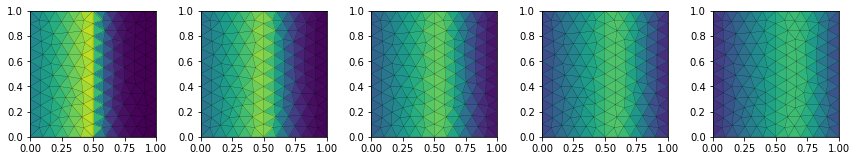

In [6]:
from time import time
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, figsize=(12,3))
runtime = 0

# Disable edge movement
em.interpolate([0,0])

i = 0
t.assign(0)
while t.value < tEnd:
    runtime -= time()

    t.value += dt
    
    uh_old.assign(uh)
    scheme.solve(target=uh)
    
    runtime += time()
    
    i += 1
    if i % 2 == 0:
        plot(uh, figure=(fig, axs[i//2-1]), clim=[0,1], colorbar=None)
        
print(f"Runtime: {runtime:.3f}s")

## Timeloop with adaptation

We need to set the `"fem.adaptation.method"` parameter to `"callback"` in order to use the non-hierarchical adaptation strategy of Dune-MMesh. Then, within the time loop, we can adapt the mesh according to the following strategy.

Runtime: 0.402s


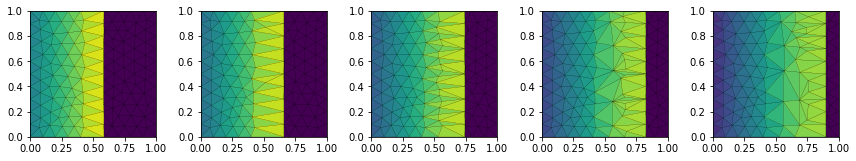

In [7]:
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )
fig.clear()
fig, axs = plt.subplots(1, 5, figsize=(12,3))
runtime = 0

uh.interpolate(u0(x))

i = 0
t.assign(0)
while t.value < tEnd:
    runtime -= time()
    
    hgrid.markElements()
    hgrid.ensureInterfaceMovement(getShifts()*dt)
    adapt([uh])

    hgrid.moveInterface(getShifts()*dt)

    em.assign(edgeMovement(gridView, getShifts()))
    t.value += dt

    uh_old.assign(uh)
    scheme.solve(target=uh)
    
    runtime += time()
    
    i += 1
    if i % 2 == 0:
        plot(uh, figure=(fig, axs[i//2-1]), clim=[0,1], colorbar=None)

print(f"Runtime: {runtime:.3f}s")